In [149]:
import os
import io
import PIL.Image, PIL.ImageDraw
import matplotlib.pyplot as plt
import requests
import logging
from tqdm import tqdm
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import clear_output, Image

# Load the models
from helpers import *
from nca import NCAModel, TrainNCA
from diffusionCA import CADiff, Diffusion
from diffusionNCA import Diffusion as FastDiffusion

from unet import UNet
from diffusion import Diffusion as UNetDiffusion

# For reloading the helpers package
import importlib
import sys
importlib.reload(sys.modules['helpers'])
importlib.reload(sys.modules['nca'])
importlib.reload(sys.modules['diffusionCA'])
importlib.reload(sys.modules['diffusionNCA'])
importlib.reload(sys.modules['unet'])
importlib.reload(sys.modules['diffusion'])

# Re-Load the models
from helpers import *
from nca import NCAModel, TrainNCA
from diffusionCA import CADiff, Diffusion
from diffusionNCA import Diffusion as FastDiffusion

from unet import UNet
from diffusion import Diffusion as UNetDiffusion

# Set cuda gpu
device_id = 0
device = torch.device(f'cuda:{device_id}' if torch.cuda.is_available() else 'cpu')
print(f'device is {device}')

device is cuda:0
Finished imports from file
device is cuda:0
Finished imports from file
device is cuda:0
device is cuda:0
device is cuda:0


# Streamline the process for loading models

In [184]:
def load_model(c_in, c_noise, h_size, p_size, noise_steps, model_name, ckpt_num, 
               img_size=28, diffusion=True, fast_diffusion=False):
    if diffusion:
        # Model
        model = CADiff(c_in=c_in, c_noise=c_noise, hidden_size=h_size, perception_size=p_size).to(device)
        PATH = f'./models/{model_name}/ckpt{ckpt_num}.pt'
        try:
            ckpt = torch.load(PATH)
        except:
            print(f'Path {PATH} does not exist')
            return 1
        
        model.load_state_dict(ckpt)
            
        # Diffusion
        if fast_diffusion:
            diffusion = FastDiffusion(c_in=c_in, c_noise=c_noise, noise_steps=noise_steps, img_size=img_size) 
        else:
            diffusion = Diffusion(c_in=c_in, c_noise=c_noise, noise_steps=noise_steps, img_size=img_size, lower=70, upper=100) 
    
        return model, diffusion
    
    # else:
    #     model = 
    
def load_unet(device, noise_steps, model_name, img_size):
    model = UNet(device=device).to(device)
    diffusion = UNetDiffusion(device=device, img_size=img_size, noise_steps=noise_steps)
    
    PATH = f'./{model_name}/ckpt.pt'
    try:
        ckpt = torch.load(PATH)
    except:
        print(f'Path {PATH} does not exist')
        return 1
    
    model.load_state_dict(ckpt)
    return model, diffusion
    

In [191]:
%%time

PATH = 'Diffusion-Models-pytorch-main/tutorial/models/'
PATH_loss = 'Diffusion-Models-pytorch-main/tutorial/losses/'

# Diffusion-based CA

# CIFAR
# cifar_model, cifar_diffusion = load_model(120, 3, 1024, 720, 500, 'CADiff_massive500_CIFAR', 330, 28)
# cifar_model1, _ = load_model(120, 3, 1024, 720, 500, 'CADiff_massive500_CIFAR', 290, 28)
# cifar_model2, cifar_diffusion2 = load_model(120, 3, 1024, 720, 1000, 'CADiff_massive1000_CIFAR', 50, 28)
# cifar_model3, cifar_diffusion3 = load_model(120, 3, 1024, 720, 500, 'CADiff_massive500_CIFAR64', 180, 64)

# # MNIST
# mnist0_model, mnist0_diffusion = load_model(90, 1, 1024, 360, 500, 'CADiff_big500_MNIST_0', 605, 28)

# mnist5_model, mnist5_diffusion = load_model(90, 1, 1024, 360, 500, 'CADiff_big500_MNIST_5', 200, 28)
# mnist5_model1, mnist5_diffusion1 = load_model(90, 1, 1024, 360, 500, 'CADiff_big500long_MNIST_5', 200, 28)

# mnist_model, mnist_diffusion = load_model(90, 1, 1024, 360, 500, 'CADiff_big500_MNIST_all', 500, 28)
mnist_model1, mnist_diffusion1 = load_model(90, 1, 1024, 360, 500, 'CADiff_big500long_MNIST_all_1', 200, 28)

# Texture
dtd_model, dtd_diffusion = load_model(120, 3, 1024, 720, 500, 'CADiff_massive500_DTD', 715, 28)

# Polkadots
polkadot_model, polkadot_diffusion = load_model(90, 3, 1024, 360, 10, 'CADiff_big_polka', 380, 28)
polkadot_model1, polkadot_diffusion1 = load_model(90, 3, 1024, 360, 500, 'CADiff_big500_polka', 140, 64)

# NCA
# nca_mnist

# polkasmall_model, polkasmall_diffusion = load_model(15, 3, 125, 45, 500, 'CADiff_small_polkadots', 200, 64, fast_diffusion)


# UNet
polkadot_unet, polkadot_unet_diffusion = load_unet(device, 500, PATH+'UNet500_polka', 64)
cifar_unet, cifar_unet_diffusion = load_unet(device, 1000, PATH+'helloworld', 64)

dtd_unet, dtd_unet_diffusion = load_unet(device, 1000, PATH+'helloworld_dtd', 64)



########################### Loss arrays
cifar_loss = load_np_array('CADiff_massive500_CIFAR')
cifar_loss3 = load_np_array('CADiff_massive500_CIFAR64')
mnist0_loss = load_np_array('CADiff_big500_MNIST_0')
mnist5_loss = load_np_array('CADiff_big500_MNIST_5')
mnist_loss = load_np_array('CADiff_big500_MNIST_all')
dtd_loss = load_np_array('CADiff_massive500_DTD')
polkadot_loss = load_np_array('CADiff_big_polka')
polkadot_loss1 = load_np_array('CADiff_big500_polka')

polkadot_unet_loss = load_np_array(PATH_loss+'UNet500_polka', foldername='')
# cifar_unet_loss = load_np_array(PATH+'helloworld')


CPU times: user 8.48 s, sys: 798 ms, total: 9.28 s
Wall time: 9.77 s


Text(0, 0.5, 'Log(10) MSE loss')

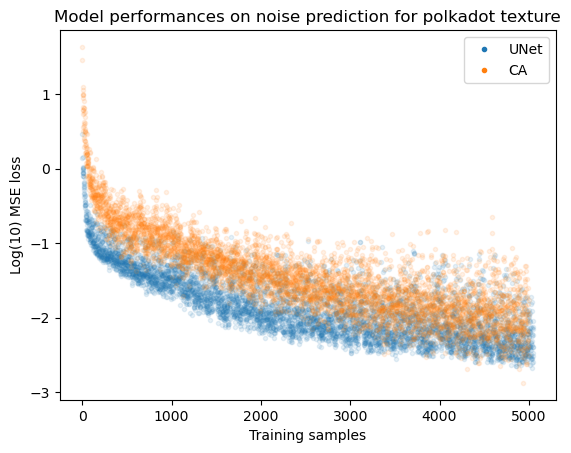

In [178]:
# plot_loss(polkadot_unet_loss)
# plot_loss(polkadot_loss1)

plt.plot(np.log10(polkadot_unet_loss), '.', alpha=0.1, label='UNet')
plt.plot(np.log10(polkadot_loss1[:5000]), '.', alpha=0.1, label='CA')
leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1) 
    
plt.title('Model performances on noise prediction for polkadot texture')
plt.xlabel('Training samples')
plt.ylabel('Log(10) MSE loss')

(-3.0, 20.0)

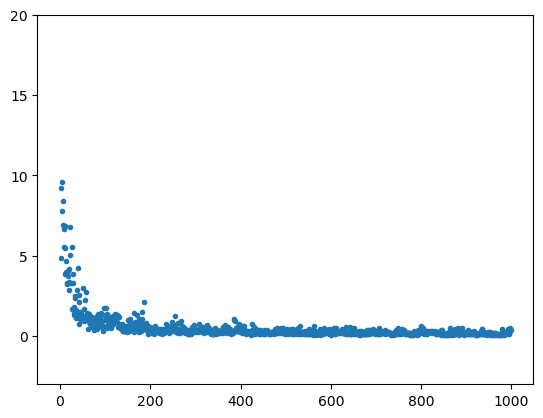

In [ ]:
plt.plot(cifar_loss[:1000], '.')
plt.ylim(bottom=-3, top=20)

In [146]:
CADiff(c_in=90, c_noise=3, hidden_size=1024, perception_size=720)

CADiff(
  (perceive): Conv2d(90, 720, kernel_size=(3, 3), stride=(1, 1), padding=same, groups=90)
  (rule): Sequential(
    (0): Conv2d(720, 1024, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(1024, 1024, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(1024, 90, kernel_size=(1, 1), stride=(1, 1))
  )
  (noise_conv): Conv2d(90, 3, kernel_size=(1, 1), stride=(1, 1))
  (time_embedding): Sequential(
    (0): SiLU()
    (1): Linear(in_features=256, out_features=90, bias=True)
  )
)

In [150]:
NCAModel()

NCAModel(
  (perceive): Conv2d(16, 48, kernel_size=(3, 3), stride=(1, 1), padding=same, groups=16)
  (conv_out): Conv2d(16, 1, kernel_size=(1, 1), stride=(1, 1))
  (rule): Sequential(
    (0): Conv2d(48, 128, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
)

In [142]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(cifar_model3)
count_parameters(mnist_model)

1538335

06:07:54 - INFO: Sampling 8 new images....
999it [01:05, 15.24it/s]


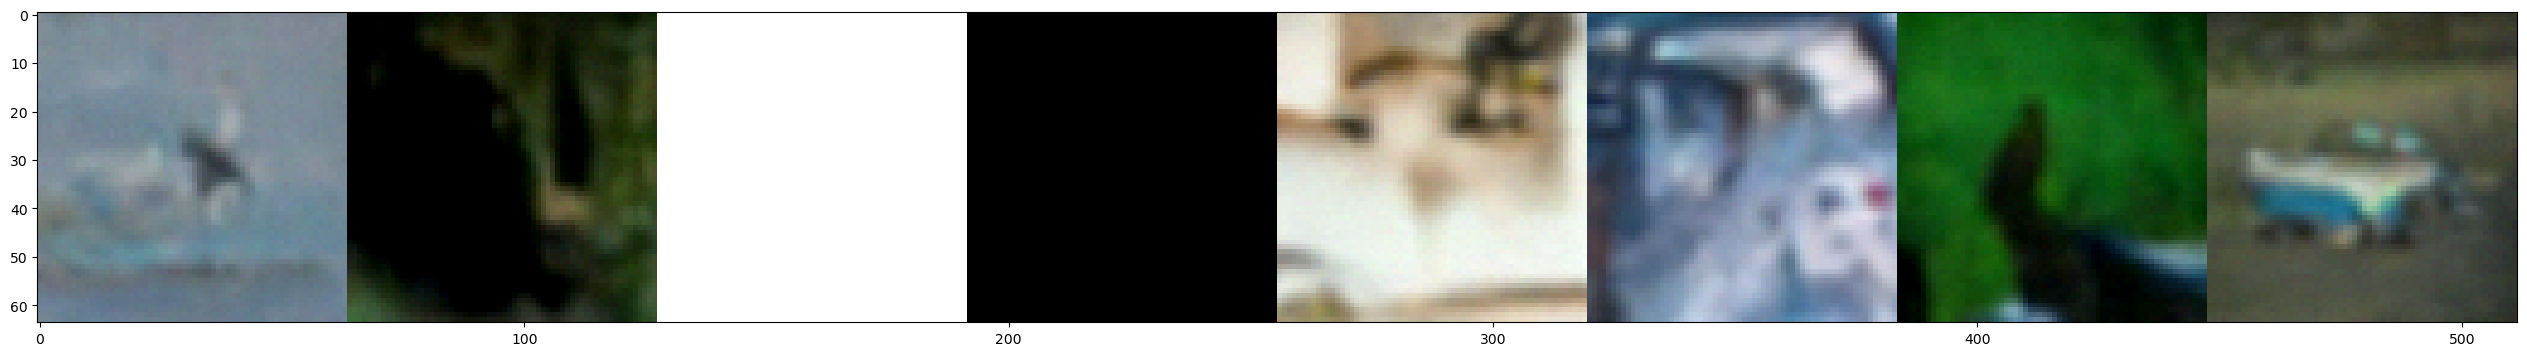

CPU times: user 1min 7s, sys: 429 ms, total: 1min 8s
Wall time: 1min 5s


In [127]:
%%time
cifar_unet_samples = cifar_unet_diffusion.sample(cifar_unet, 8)
plot_images(cifar_unet_samples)

06:37:55 - INFO: Sampling 8 new images....
999it [01:07, 14.75it/s]


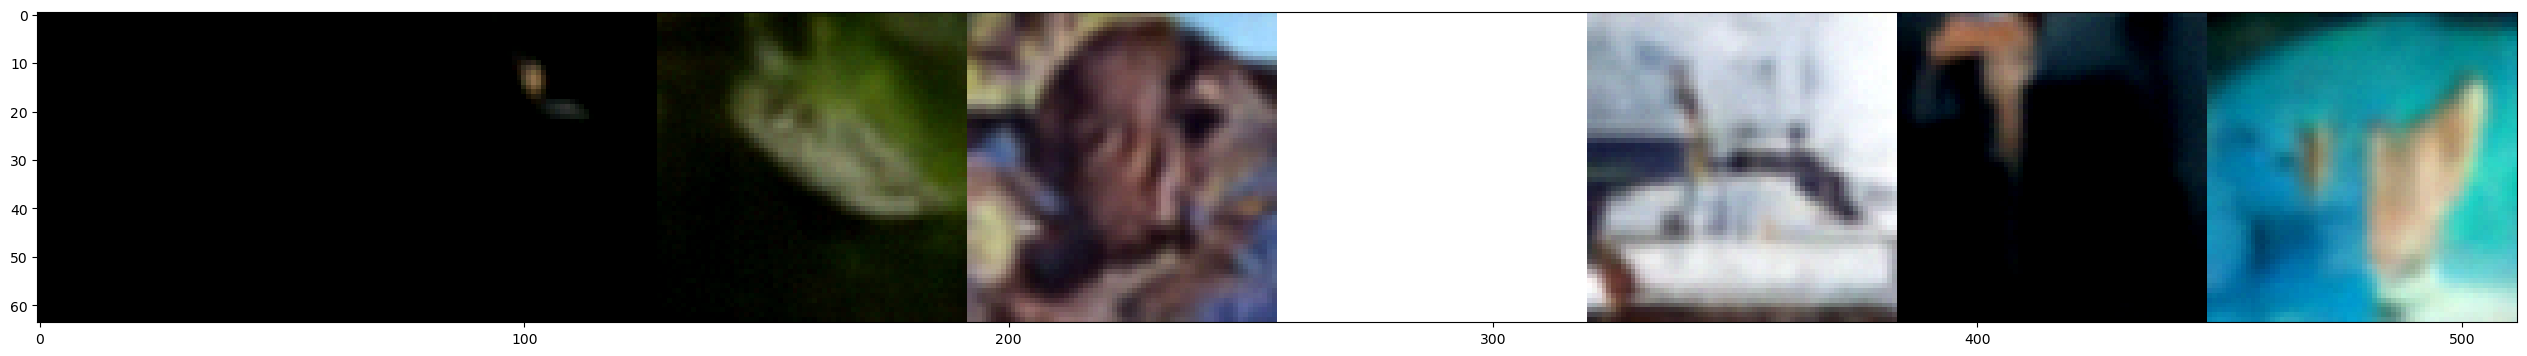

CPU times: user 1min 9s, sys: 413 ms, total: 1min 10s
Wall time: 1min 8s


In [129]:
%%time
cifar_unet_samples = cifar_unet_diffusion.sample(cifar_unet, 8)
plot_images(cifar_unet_samples)

06:41:25 - INFO: Sampling 8 new images...


Sampling 8 images


499it [02:44,  3.04it/s]


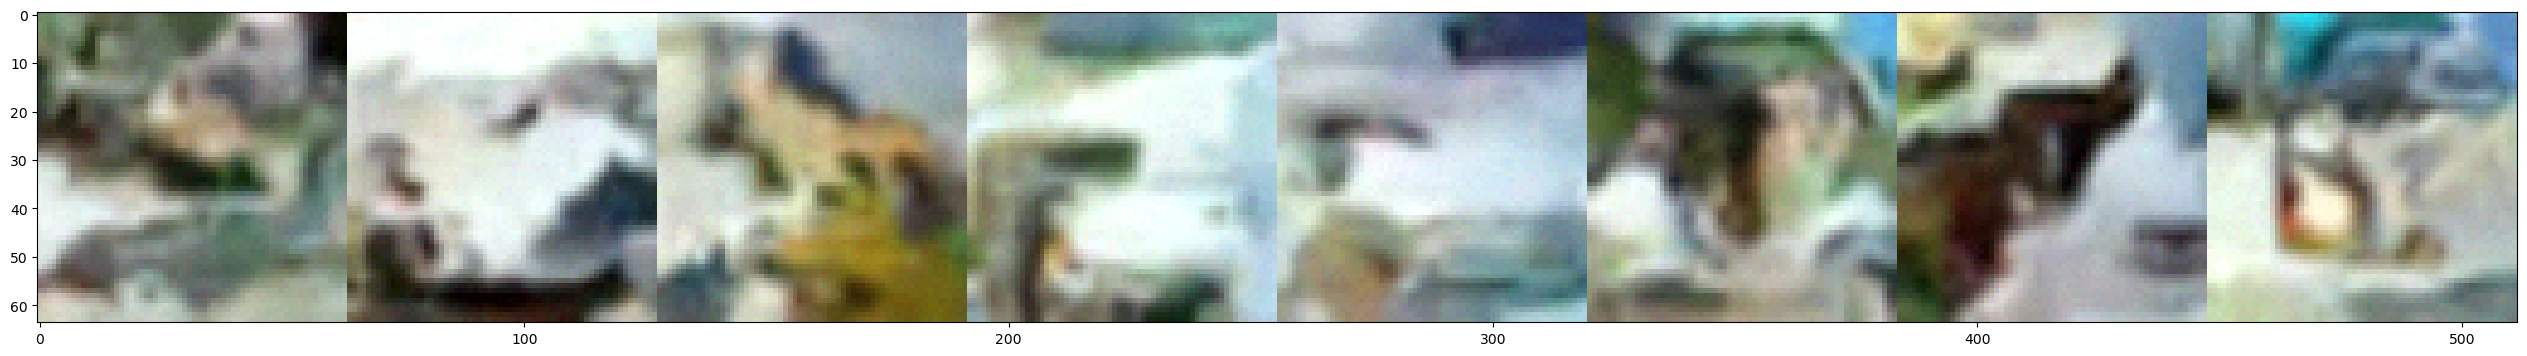

CPU times: user 2min 46s, sys: 548 ms, total: 2min 47s
Wall time: 2min 44s


In [136]:
%%time
cifar_samples3 = cifar_diffusion3.sample(cifar_model3, 8)
plot_images(cifar_samples3)

05:40:01 - INFO: Sampling 8 new images...


Sampling 8 images


499it [02:46,  2.99it/s]


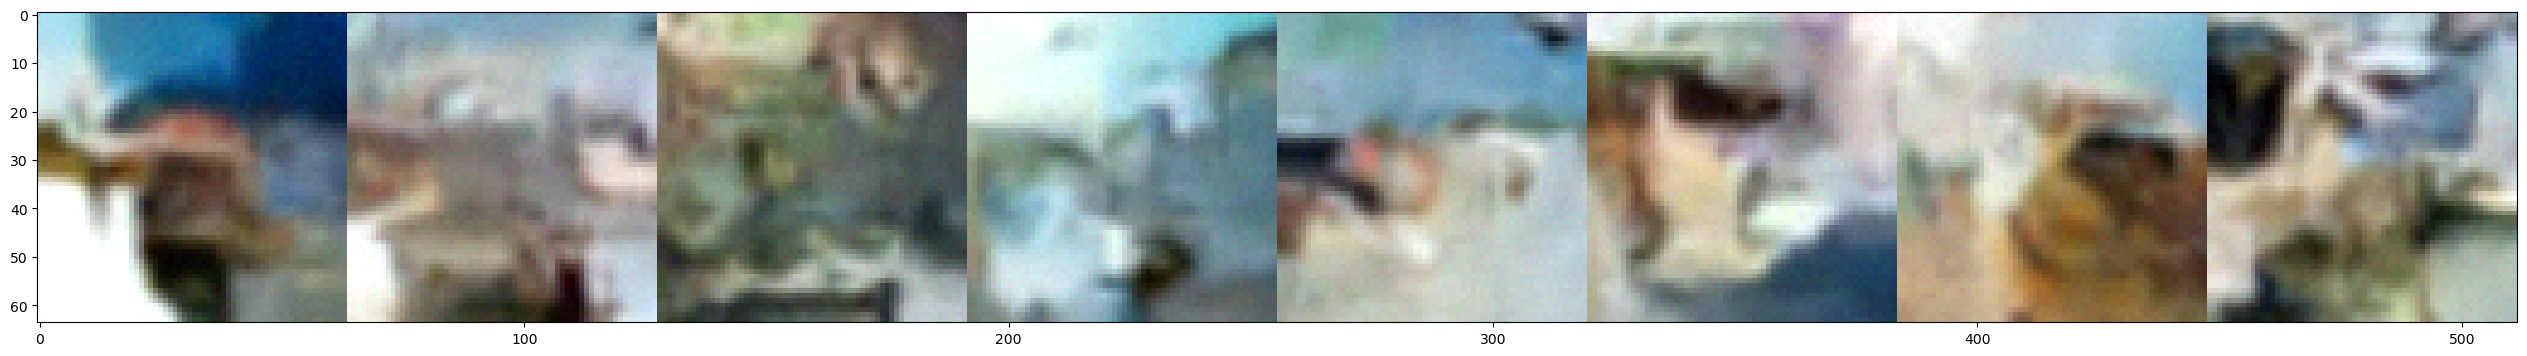

CPU times: user 2min 48s, sys: 550 ms, total: 2min 49s
Wall time: 2min 47s


In [98]:
%%time
cifar_samples3 = cifar_diffusion3.sample(cifar_model3, 8)
plot_images(cifar_samples3)

In [163]:
def plot_images(images, filename=None, cmap='viridis'):
    plt.figure(figsize=(32, 32))
    plt.imshow(torch.cat([
        torch.cat([i for i in images.cpu()], dim=-1)
    ], dim=-2).permute(1, 2, 0).cpu(), cmap=cmap)
    if filename is not None:
        plt.savefig(f'images/{filename}.png')    
    plt.show()

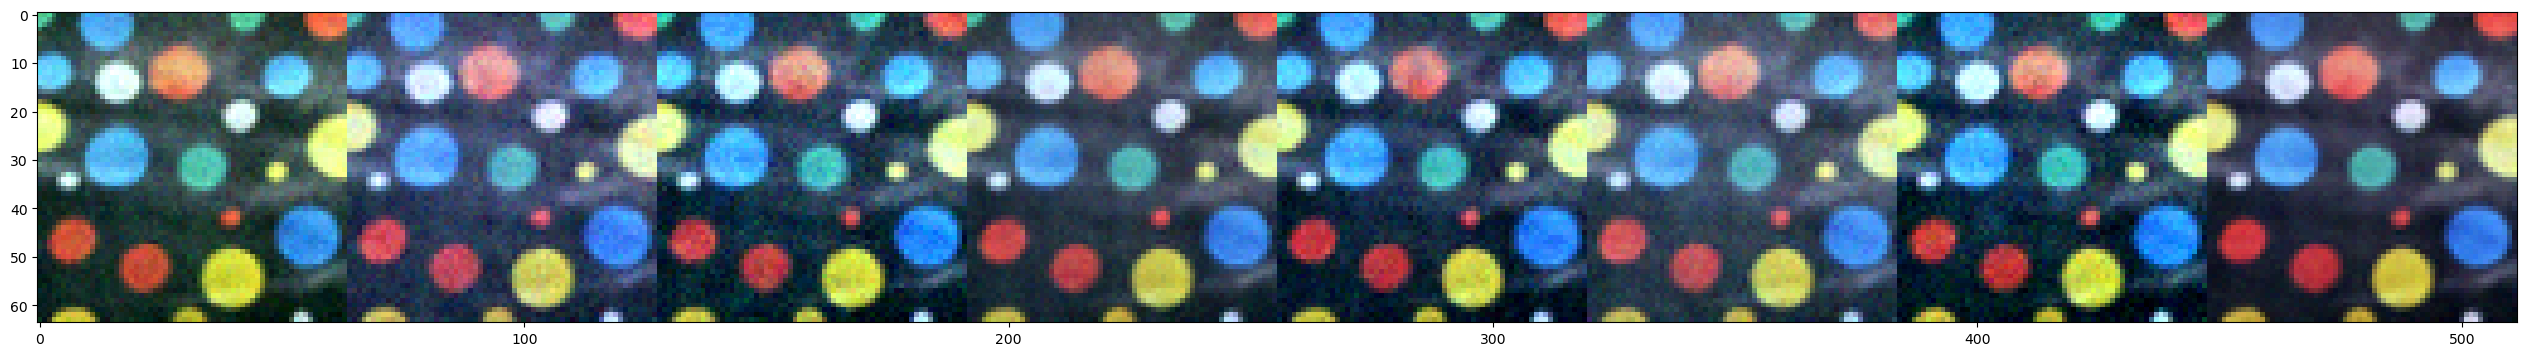

In [164]:
# %%time
# polkadot_unet_samples = polkadot_unet_diffusion.sample(polkadot_unet, 8)
plot_images(polkadot_unet_samples, filename='unet_polkadots')

03:46:59 - INFO: Sampling 8 new images...


Sampling 8 images


499it [00:49, 10.13it/s]


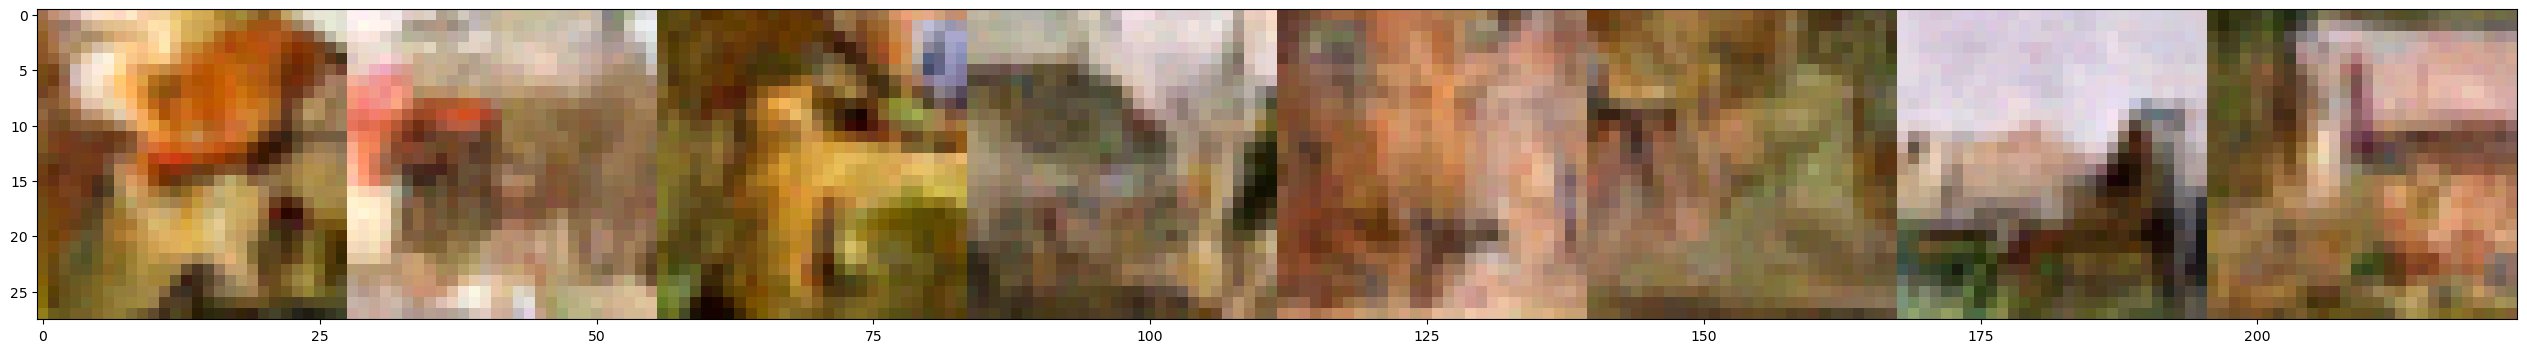

CPU times: user 49.7 s, sys: 179 ms, total: 49.8 s
Wall time: 49.7 s


In [54]:
%%time
cifar_samples = cifar_diffusion.sample(cifar_model, 8)
plot_images(cifar_samples)

05:46:01 - INFO: Sampling 8 new images...


Sampling 8 images


499it [02:29,  3.34it/s]


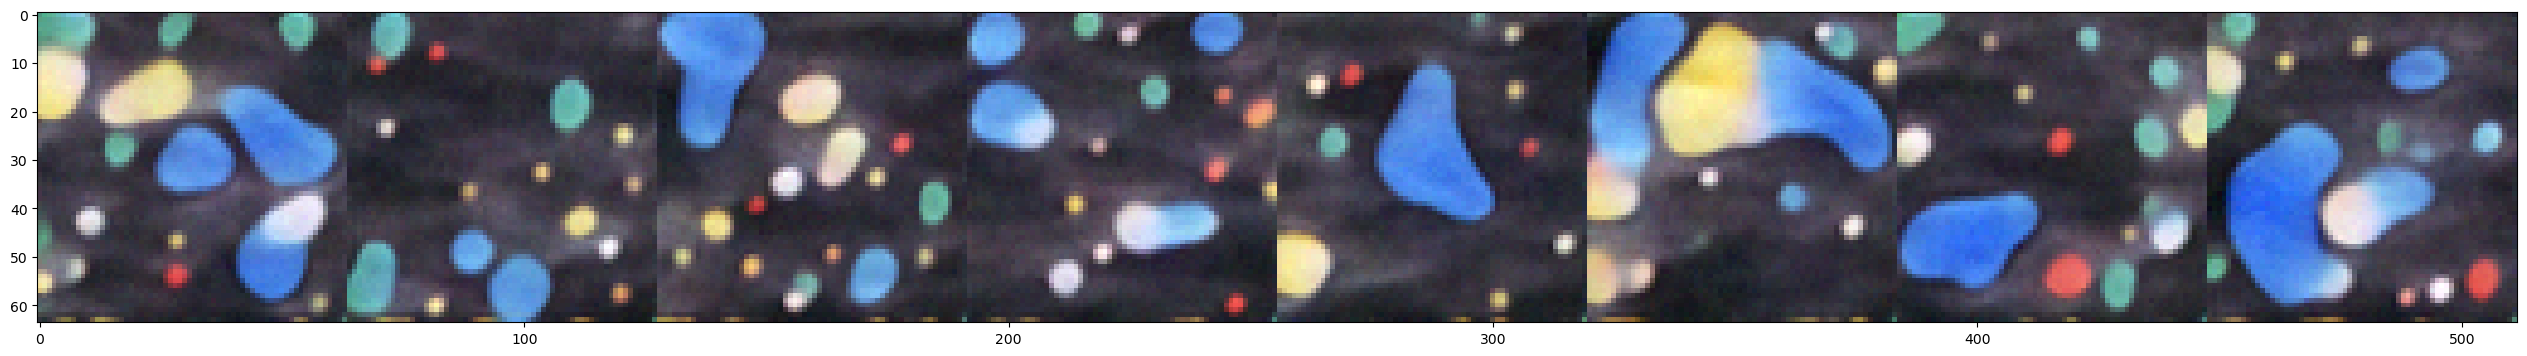

CPU times: user 2min 31s, sys: 486 ms, total: 2min 31s
Wall time: 2min 29s


In [89]:
%%time
polkadot1_samples = polkadot_diffusion1.sample(polkadot_model1, 8)
plot_images(polkadot1_samples)

05:58:21 - INFO: Sampling 4 new images...


Sampling 4 images


999it [02:53,  5.75it/s]


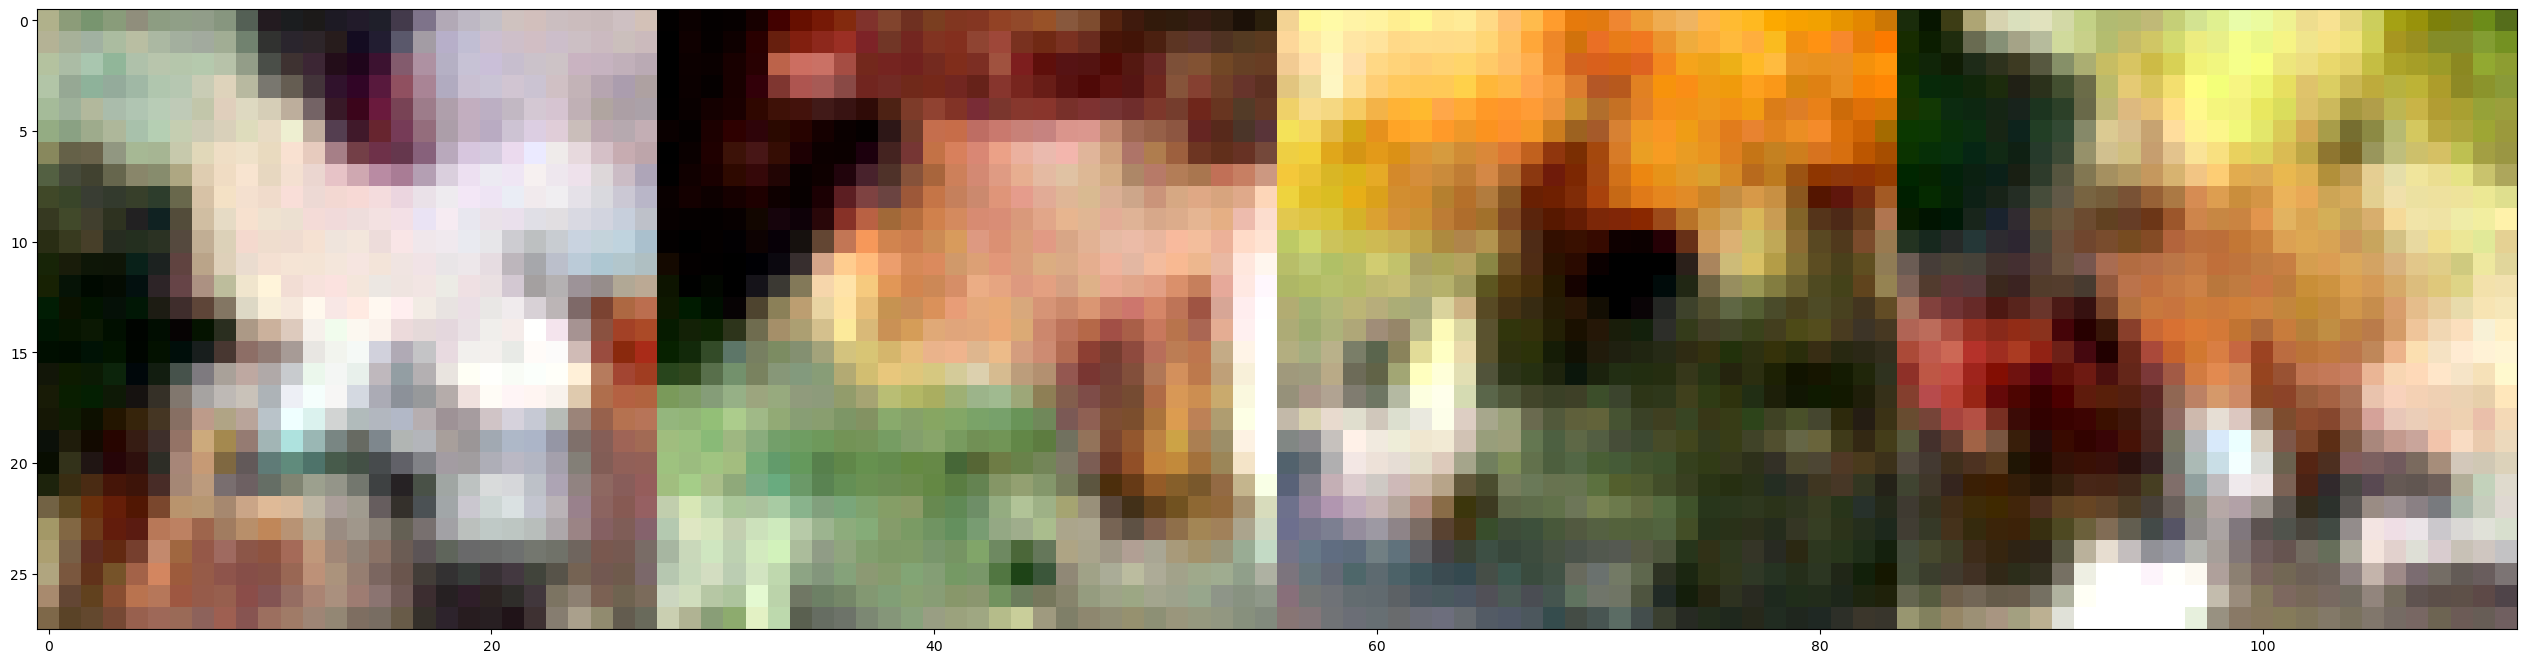

CPU times: user 1min 34s, sys: 469 ms, total: 1min 34s
Wall time: 2min 54s


In [93]:
%%time
cifar_samples2 = cifar_diffusion2.sample(cifar_model2, 4)
plot_images(cifar_samples2)

03:08:36 - INFO: Sampling 8 new images...


Sampling 8 images


499it [00:48, 10.29it/s]


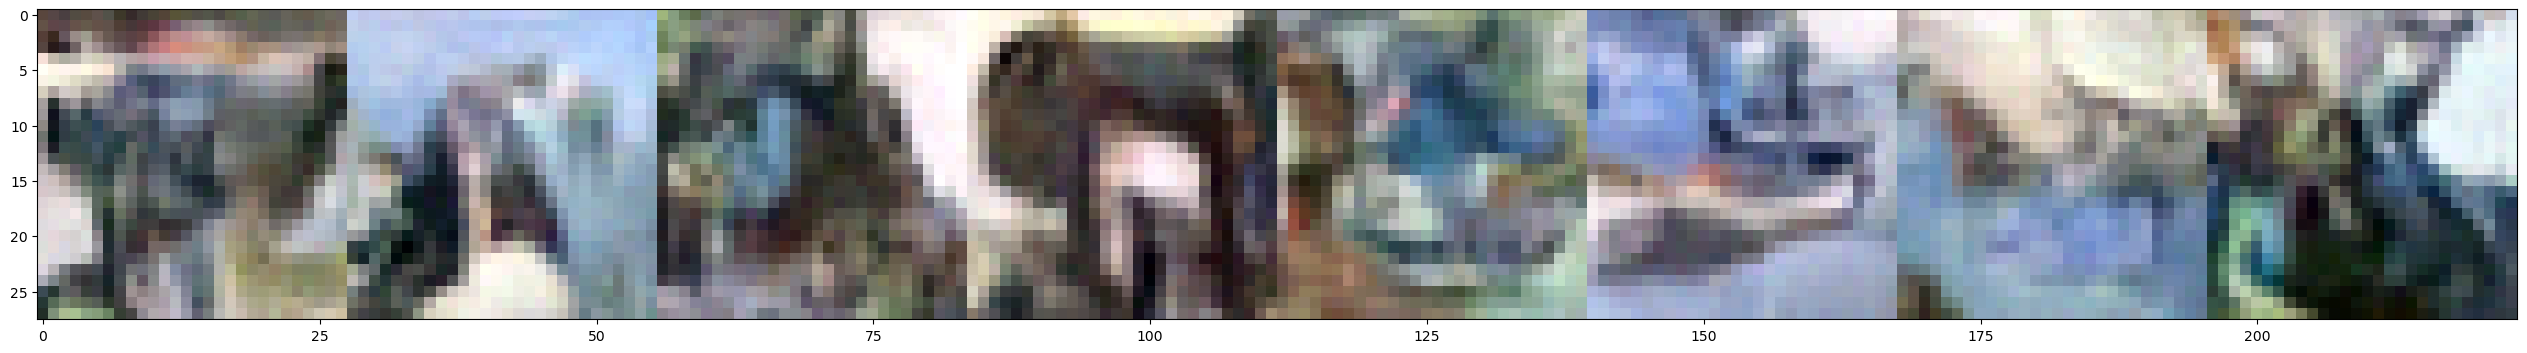

CPU times: user 48.2 s, sys: 190 ms, total: 48.4 s
Wall time: 48.9 s


In [40]:
%%time
cifar_samples1 = cifar_diffusion.sample(cifar_model1, 8)
plot_images(cifar_samples1)

05:23:43 - INFO: Sampling 8 new images...


Sampling 8 images


499it [00:43, 11.59it/s]


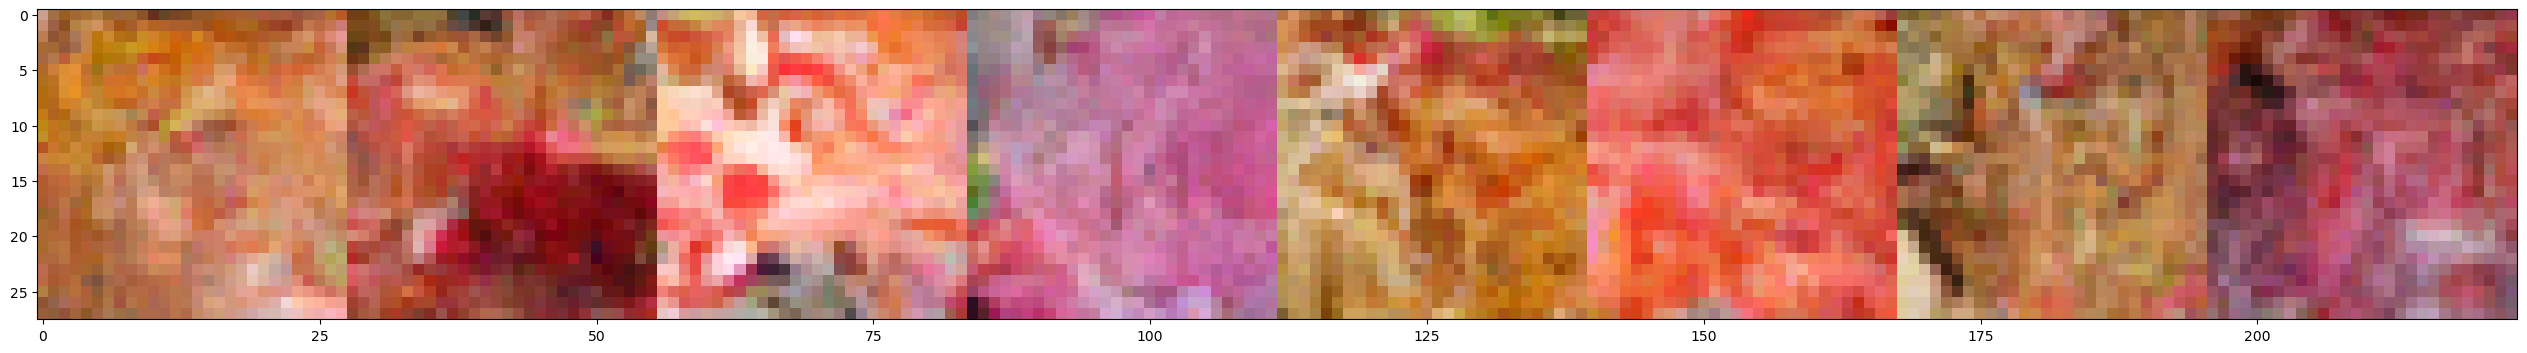

CPU times: user 43.4 s, sys: 126 ms, total: 43.5 s
Wall time: 43.5 s


In [87]:
%%time
dtd_samples = dtd_diffusion.sample(dtd_model, 8)
plot_images(dtd_samples)

03:36:28 - INFO: Sampling 8 new images...


Sampling 8 images


499it [01:58,  4.22it/s]


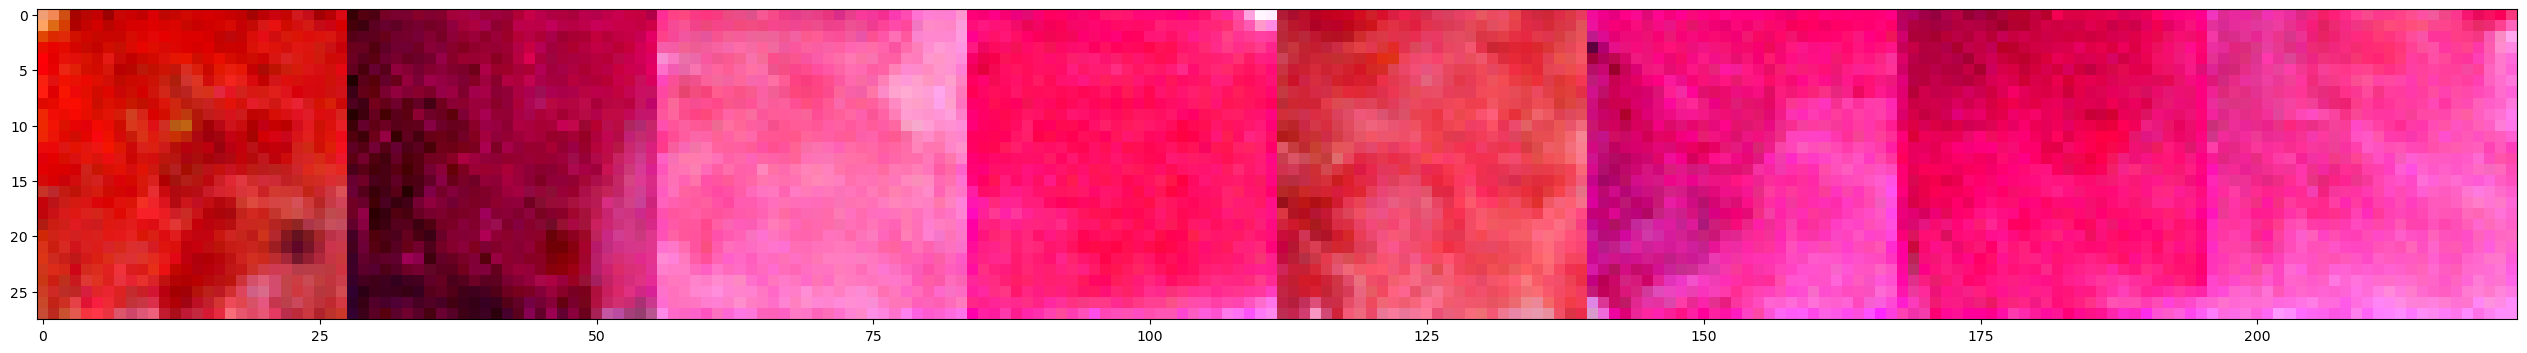

CPU times: user 1min 39s, sys: 954 ms, total: 1min 40s
Wall time: 2min 1s


In [193]:
%%time
dtd_samples = dtd_diffusion.sample(dtd_model, 8)
plot_images(dtd_samples)

03:17:06 - INFO: Sampling 8 new images....
999it [01:08, 14.53it/s]


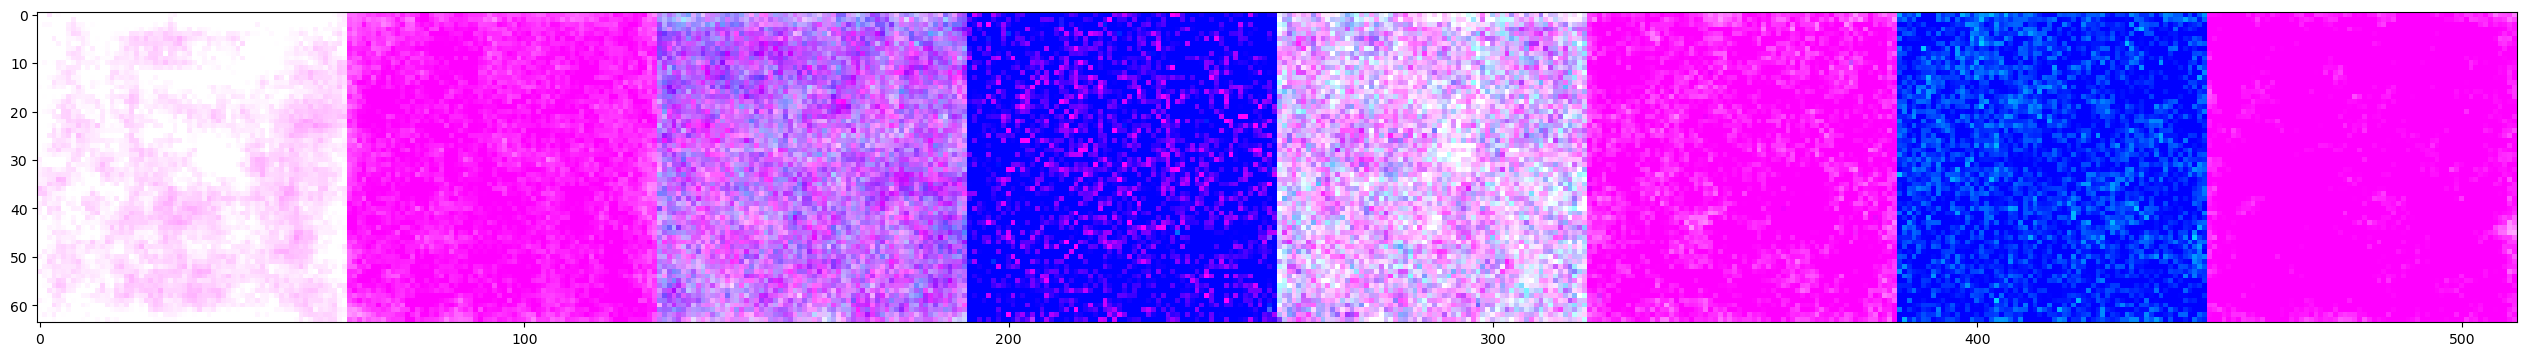

In [192]:
dtd_unet_samples = dtd_unet_diffusion.sample(dtd_unet, 8)
plot_images(dtd_unet_samples)

03:13:07 - INFO: Sampling 8 new images...


Sampling 8 images


499it [00:49, 10.18it/s]


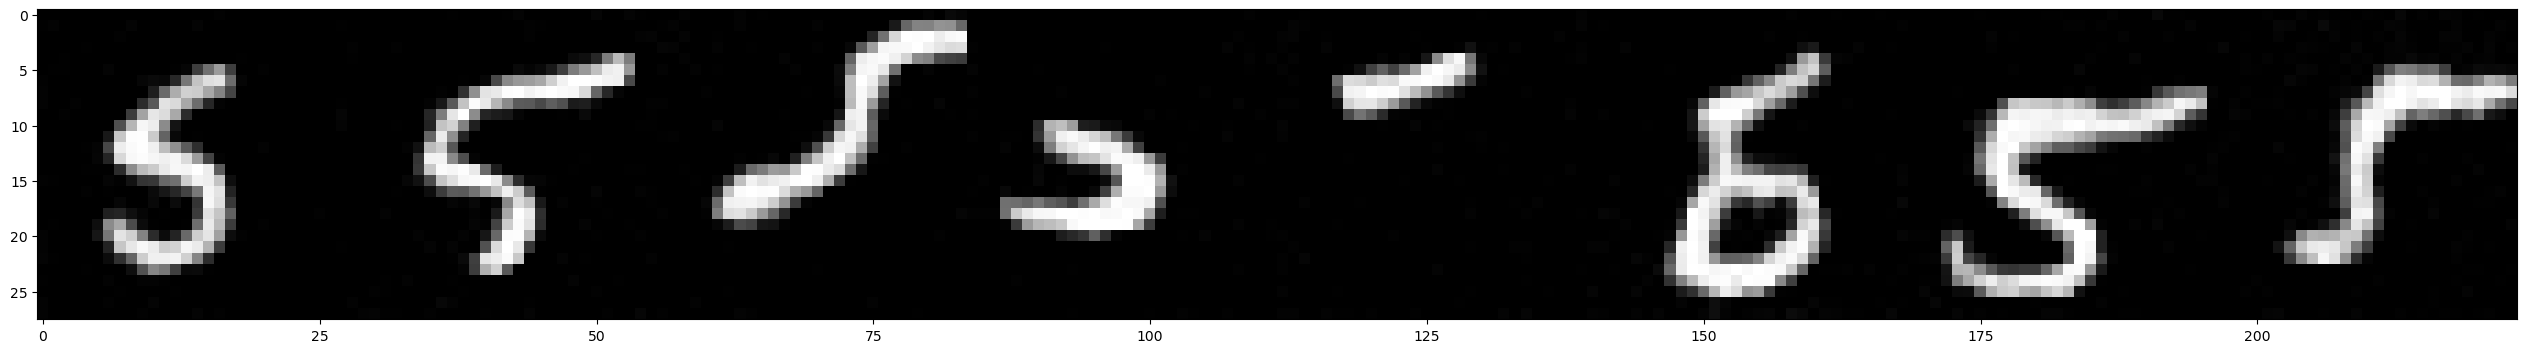

CPU times: user 49.3 s, sys: 218 ms, total: 49.5 s
Wall time: 49.3 s


In [45]:
%%time
mnist5_samples = mnist5_diffusion.sample(mnist5_model, 8)
plot_images(mnist5_samples, cmap='gray')

02:41:31 - INFO: Sampling 8 new images...


Sampling 8 images


499it [00:51,  9.68it/s]


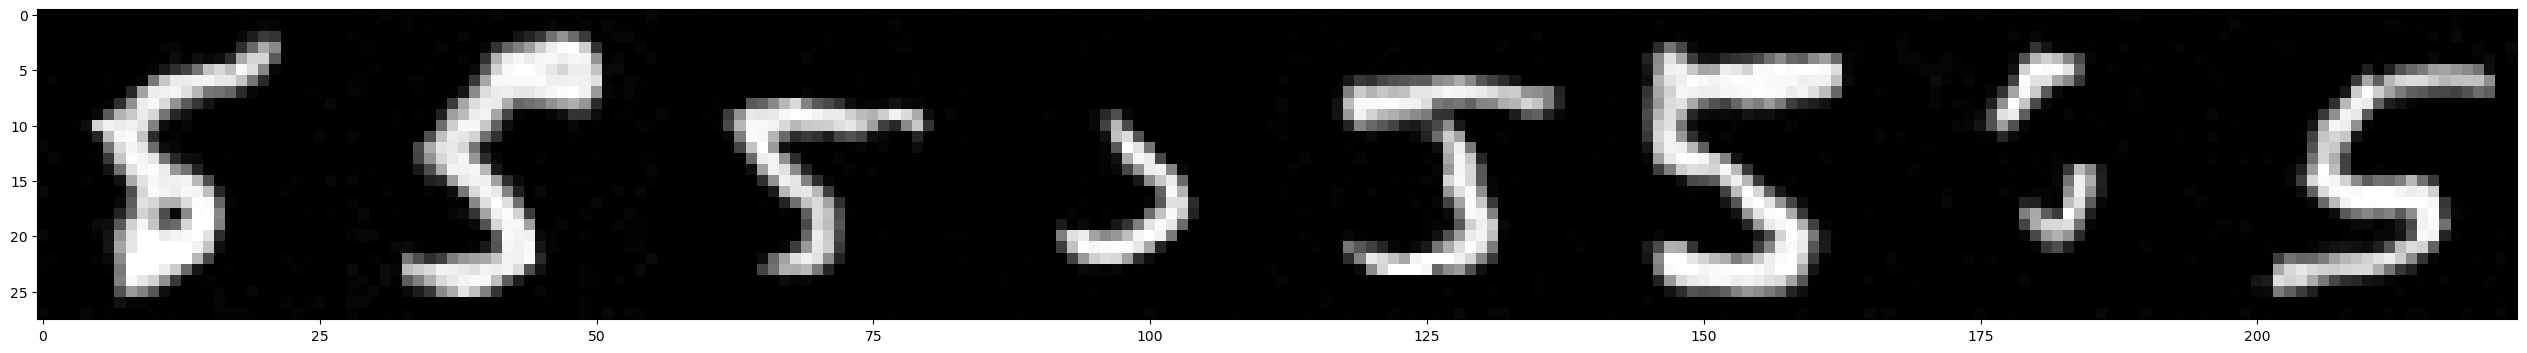

CPU times: user 44.6 s, sys: 358 ms, total: 44.9 s
Wall time: 54 s


In [180]:
%%time
mnist5_samples1 = mnist5_diffusion1.sample(mnist5_model1, 8)
plot_images(mnist5_samples1, cmap='gray')

02:42:25 - INFO: Sampling 8 new images...


Sampling 8 images


499it [00:46, 10.64it/s]


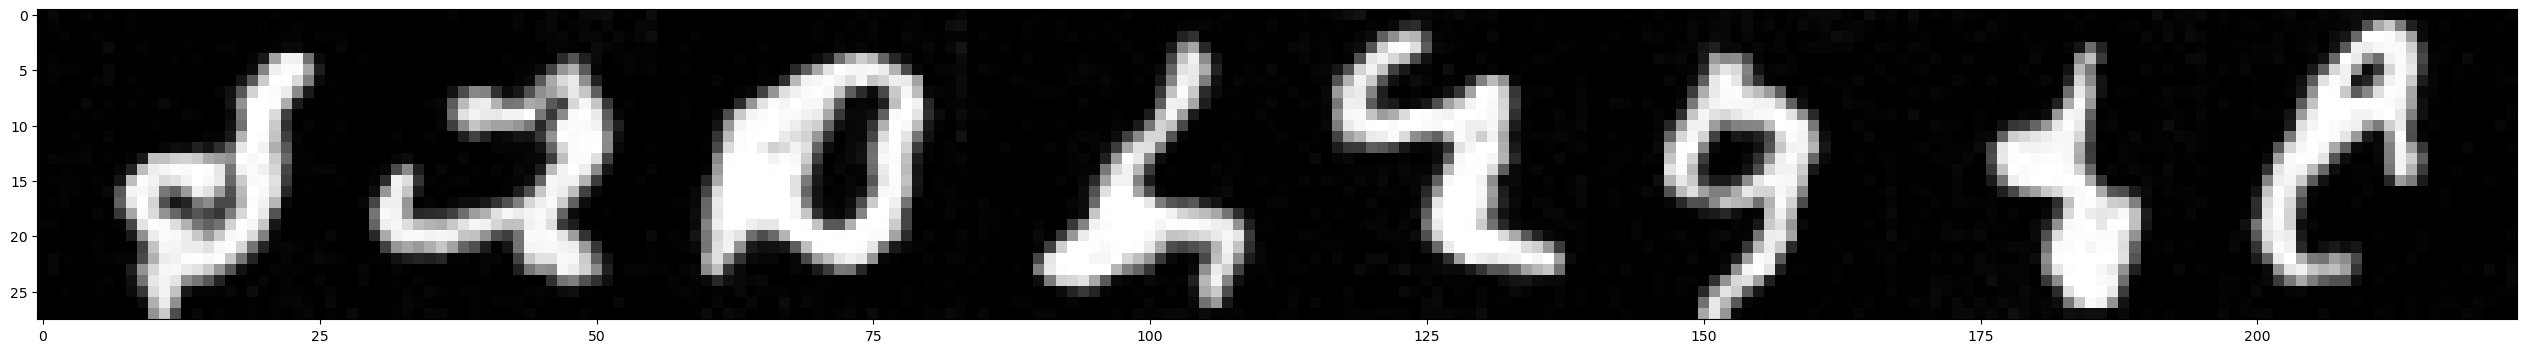

CPU times: user 45.3 s, sys: 353 ms, total: 45.7 s
Wall time: 47.3 s


In [181]:
%%time
mnist_samples1 = mnist_diffusion1.sample(mnist_model1, 8)
plot_images(mnist_samples1, cmap='gray')

02:47:19 - INFO: Sampling 8 new images...


Sampling 8 images


499it [01:52,  4.43it/s]


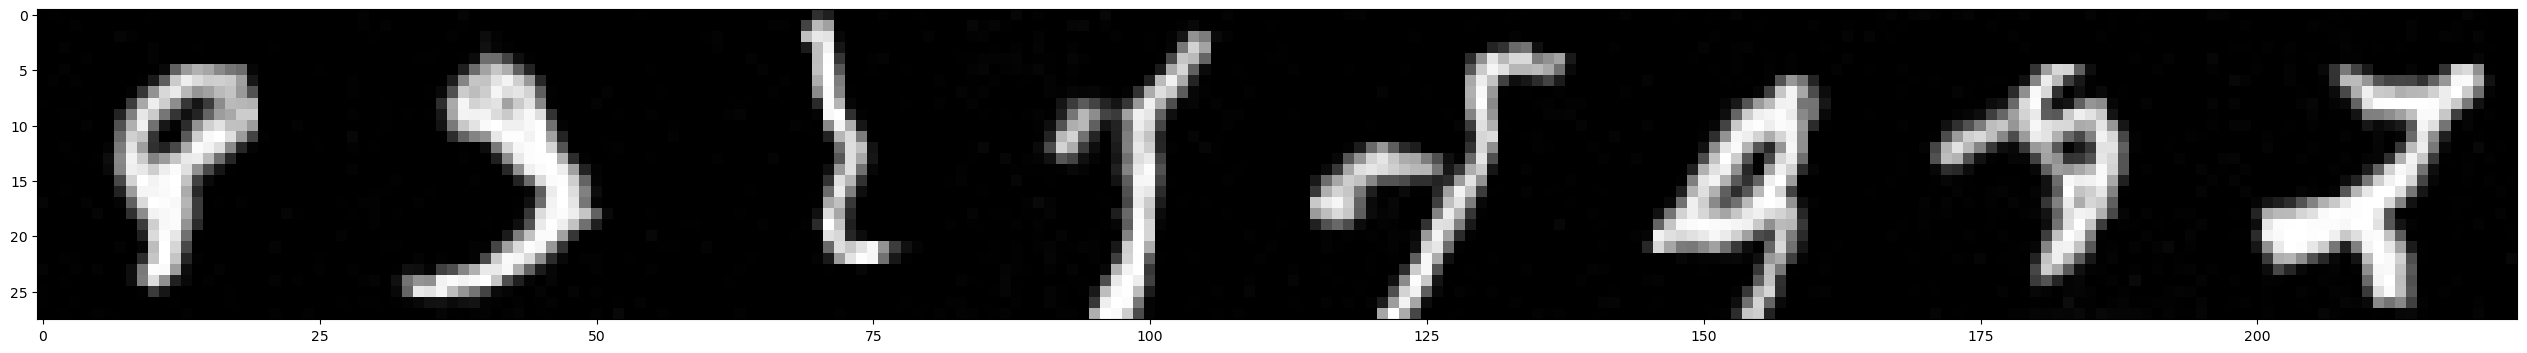

In [187]:
## LONG 

mnist_samples1 = mnist_diffusion1.sample(mnist_model1, 8)
plot_images(mnist_samples1, cmap='gray')

02:49:54 - INFO: Sampling 8 new images...


Sampling 8 images


499it [00:43, 11.40it/s]


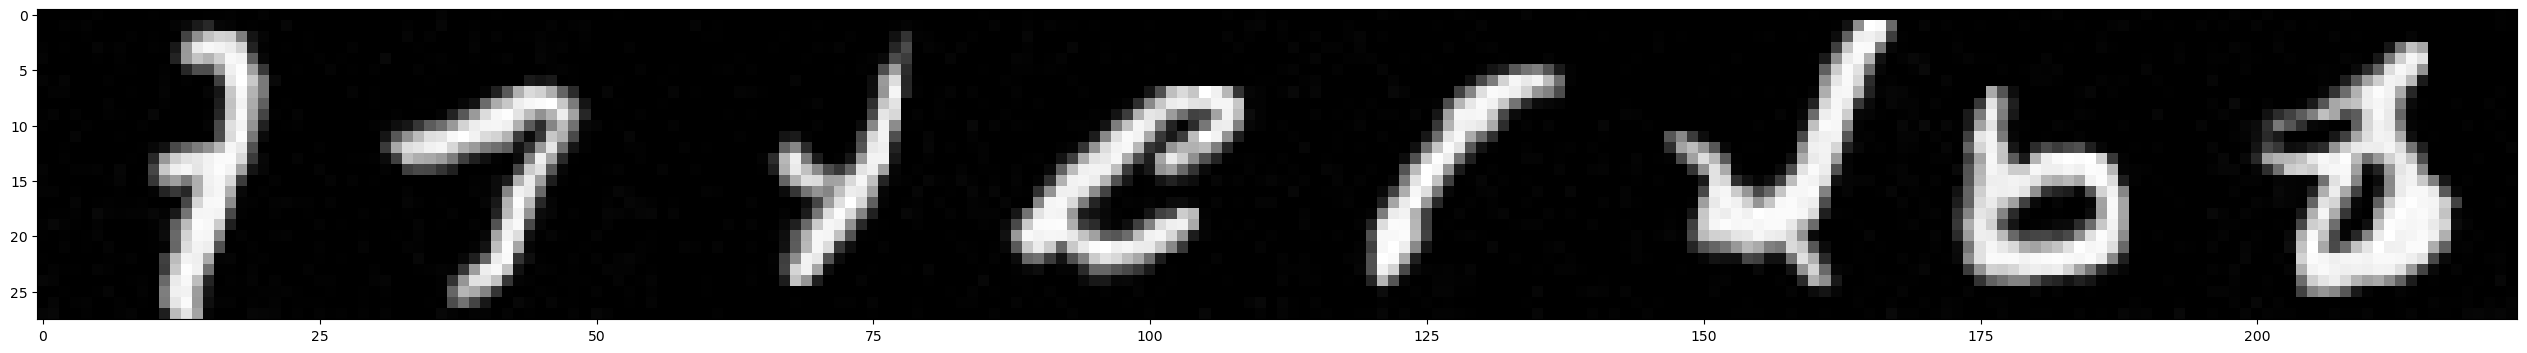

CPU times: user 44 s, sys: 434 ms, total: 44.5 s
Wall time: 44.7 s


In [188]:
%%time
mnist_samples = mnist_diffusion.sample(mnist_model, 8)
plot_images(mnist_samples, cmap='gray')

03:15:19 - INFO: Sampling 8 new images...


Sampling 8 images


499it [00:48, 10.32it/s]


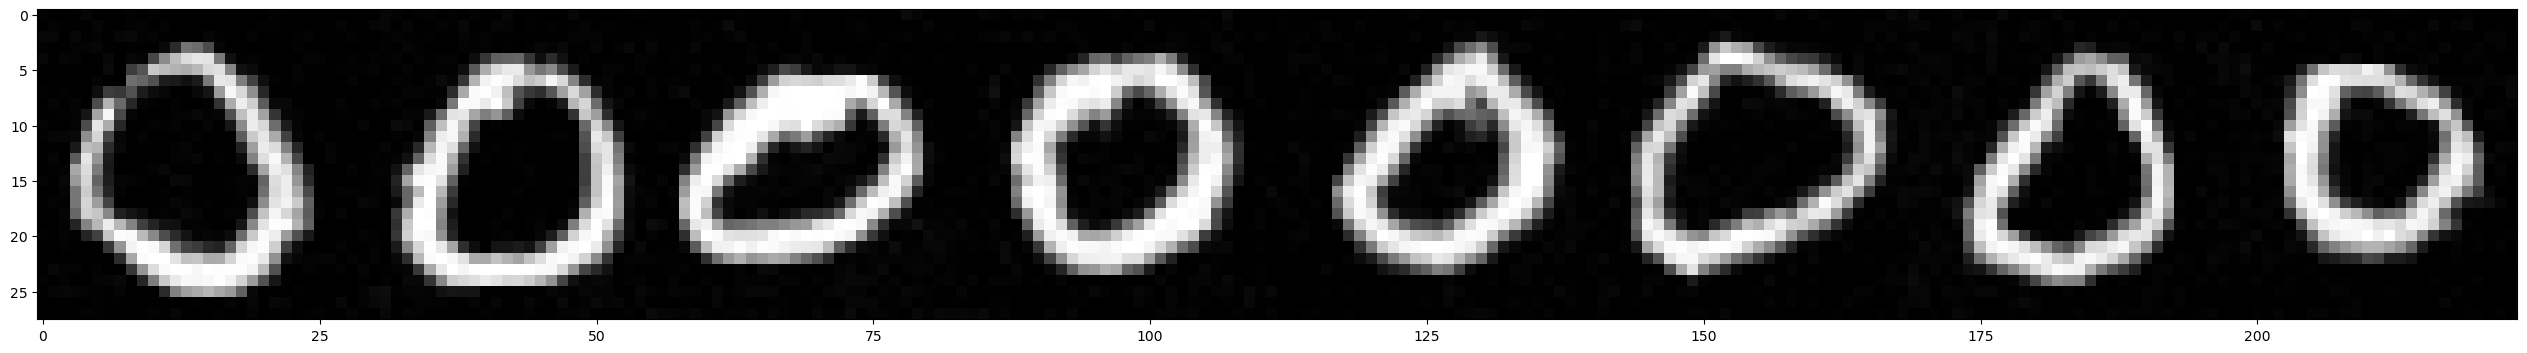

CPU times: user 48.6 s, sys: 224 ms, total: 48.9 s
Wall time: 48.7 s


In [48]:
%%time
mnist0_samples = mnist0_diffusion.sample(mnist0_model, 8)
plot_images(mnist0_samples, cmap='gray')

03:34:54 - INFO: Sampling 8 new images...


Sampling 8 images


9it [00:00, 10.15it/s]


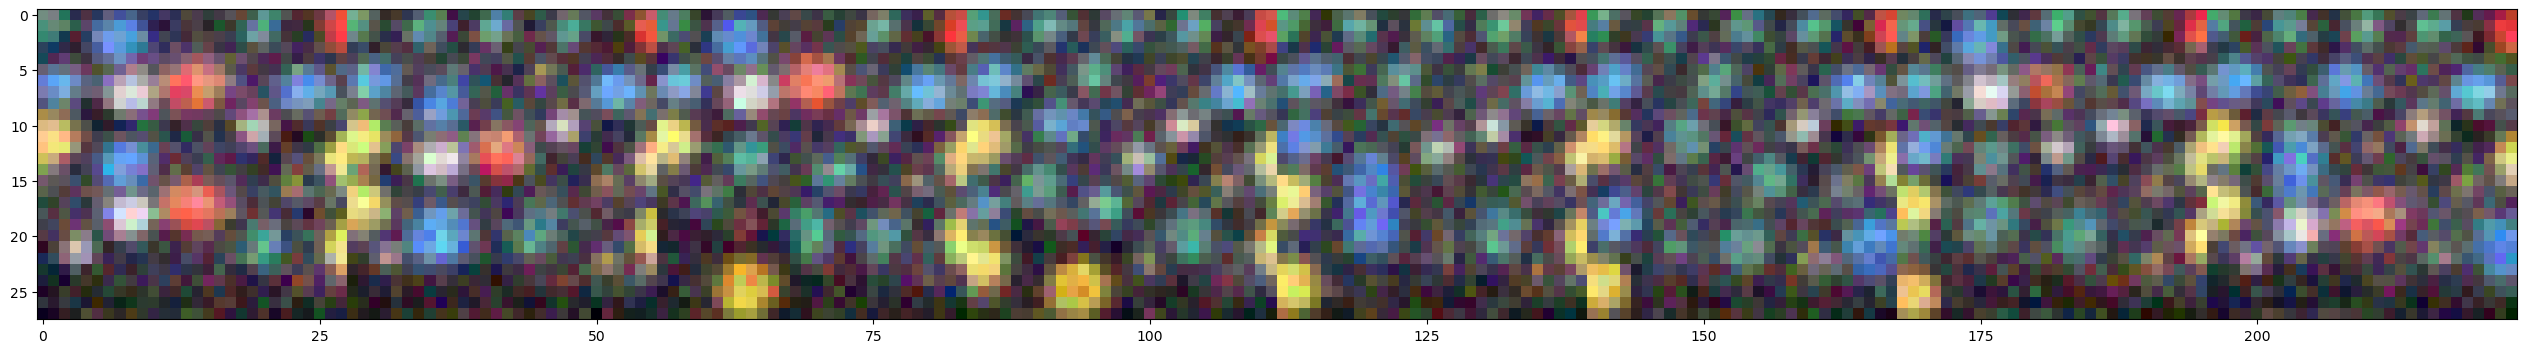

CPU times: user 1.1 s, sys: 56.3 ms, total: 1.15 s
Wall time: 1.2 s


In [52]:
%%time
polkadot_samples = polkadot_diffusion.sample(polkadot_model, 8)
plot_images(polkadot_samples)

I am exploring the CA's ability to reproduce the results of diffusion models. 